In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
import spinesTS
spinesTS.__version__

'0.3.4'

In [3]:
from spinesTS.preprocessing import split_series
from spinesTS.plotting import plot2d
from sklearn.metrics import r2_score

In [4]:
from spinesTS.data import BuiltInSeriesData
from spinesTS.nn import *
from spinesTS.metrics import mean_absolute_error
from spinesTS.metrics import mean_absolute_percentage_error

In [5]:
series_data = BuiltInSeriesData()

+----+----------------------+----------------------------------------------------------------------+
|    | ds name              | columns                                                              |
+----+----------------------+----------------------------------------------------------------------+
|  0 | AirPassengers        | Month, #Passengers                                                   |
|  1 | ETTh1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  2 | ETTh2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  3 | ETTm1                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  4 | ETTm2                | date, HUFL, HULL, MUFL, MULL, LUFL, LULL, OT                         |
|  5 | Electric_Production  | date, value                                                          |
|  6 | M3_monthly_FTS       | series_id, method_id, forecast, horizon, timestamp, origin_ti

In [6]:
cs = series_data['Electric_Production']

x_train, x_test, y_train, y_test = split_series(cs['value'], cs['value'], 128, 30, train_size=0.9)

In [7]:
x_train.shape, x_test.shape

((216, 128), (24, 128))

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

scaler2 = MinMaxScaler()
y_train = scaler2.fit_transform(y_train)
y_test = scaler2.transform(y_test)

# StackingRNN

Using cpu backend
Epoch 1/3000  
7/7 - p0 - loss: 0.1705 - mae: 0.2375 - val_loss: 0.2109 - val_mae: 0.2109 - 0.49s/epoch - 0.071s/step
Epoch 2/3000  
7/7 - p0 - loss: 0.2440 - mae: 0.2788 - val_loss: 0.1879 - val_mae: 0.1879 - 0.45s/epoch - 0.064s/step
Epoch 3/3000  
7/7 - p0 - loss: 0.1642 - mae: 0.1748 - val_loss: 0.1842 - val_mae: 0.1842 - 0.43s/epoch - 0.062s/step
Epoch 4/3000  
7/7 - p0 - loss: 0.1856 - mae: 0.1840 - val_loss: 0.1731 - val_mae: 0.1731 - 0.47s/epoch - 0.067s/step
Epoch 5/3000  
7/7 - p1 - loss: 0.1700 - mae: 0.1640 - val_loss: 0.1805 - val_mae: 0.1805 - 0.44s/epoch - 0.063s/step
Epoch 6/3000  
7/7 - p0 - loss: 0.1747 - mae: 0.1657 - val_loss: 0.1730 - val_mae: 0.1730 - 0.47s/epoch - 0.067s/step
Epoch 7/3000  
7/7 - p1 - loss: 0.1655 - mae: 0.1687 - val_loss: 0.1871 - val_mae: 0.1871 - 0.43s/epoch - 0.062s/step
Epoch 8/3000  
7/7 - p0 - loss: 0.1618 - mae: 0.1621 - val_loss: 0.1694 - val_mae: 0.1694 - 0.44s/epoch - 0.063s/step
Epoch 9/3000  
7/7 - p1 - loss: 0.1788

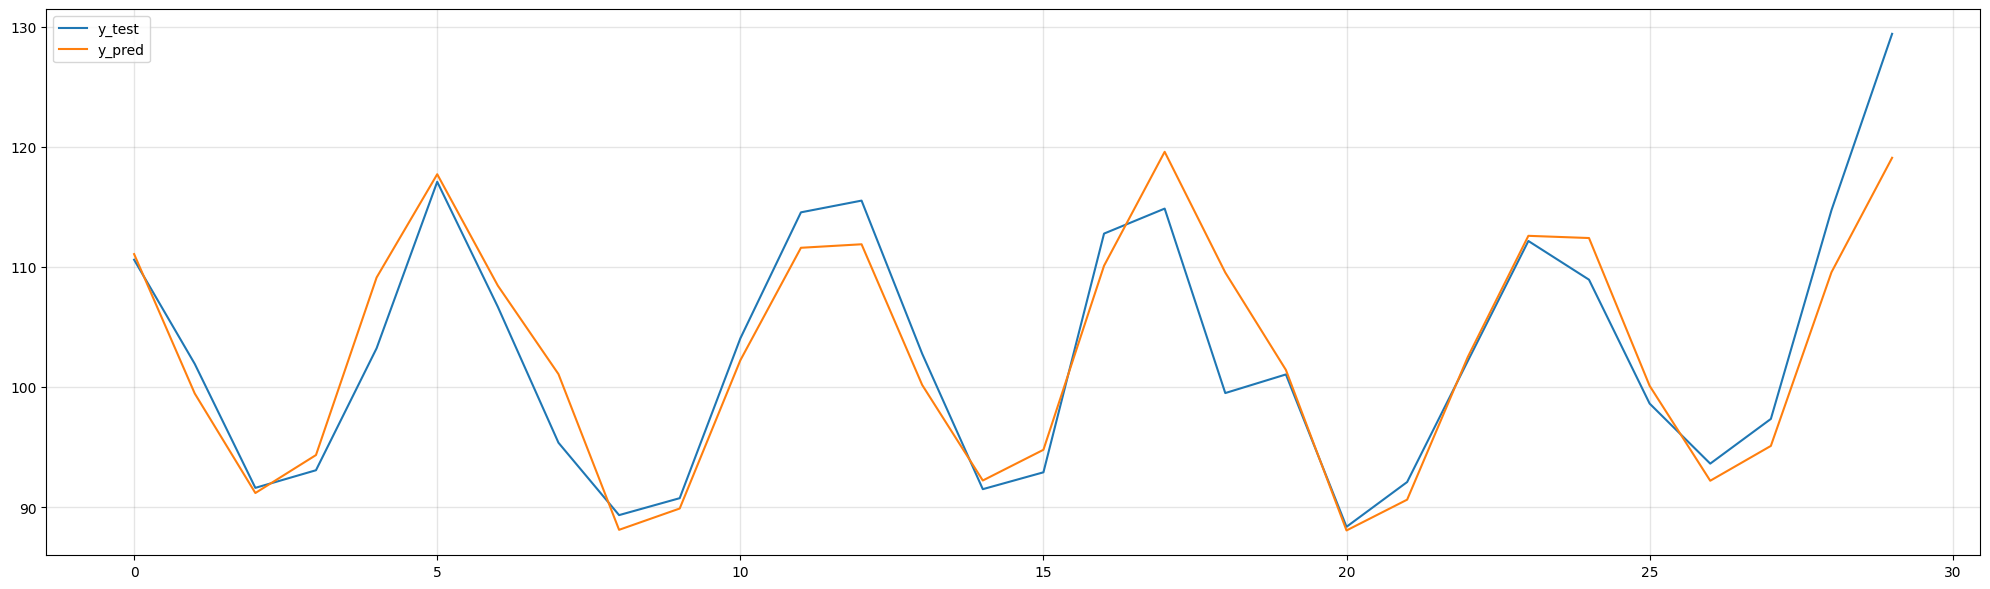

In [9]:
# selu在attention后
model = StackingRNN(128, 30, random_seed=42, loss_fn='mae', learning_rate=0.001, dropout=0.1,
                    stack_num=4, num_layers=1, bidirectional=True, device='cpu')
model.fit(x_train, y_train, eval_set=(x_test, y_test), batch_size=32,
             min_delta=0, patience=100, epochs=3000, verbose=True, lr_scheduler=None)
y_pred_inverse = scaler2.inverse_transform(model.predict(x_test))

y_test_inverse = scaler2.inverse_transform(y_test)

print(f"r2: {r2_score(y_test_inverse.T, y_pred_inverse.T)}")
print(f"mae: {mean_absolute_error(y_test_inverse, y_pred_inverse)}")
print(f"mape: {mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)}")
a = plot2d(y_test_inverse, y_pred_inverse, eval_slices='[-1]', labels=['y_test', 'y_pred'], figsize=(20, 6))

# GAUNet

Using cpu backend
Epoch 1/3000  
55/55 - p0 - loss: 0.1605 - mae: 0.2696 - val_loss: 0.0907 - val_mae: 0.0907 - 0.26s/epoch - 0.005s/step
Epoch 2/3000  
55/55 - p0 - loss: 0.1435 - mae: 0.1930 - val_loss: 0.0632 - val_mae: 0.0632 - 0.26s/epoch - 0.005s/step
Epoch 3/3000  
55/55 - p0 - loss: 0.1341 - mae: 0.1784 - val_loss: 0.0520 - val_mae: 0.0520 - 0.25s/epoch - 0.005s/step
Epoch 4/3000  
55/55 - p1 - loss: 0.1286 - mae: 0.1698 - val_loss: 0.0544 - val_mae: 0.0544 - 0.26s/epoch - 0.005s/step
Epoch 5/3000  
55/55 - p2 - loss: 0.1215 - mae: 0.1621 - val_loss: 0.0525 - val_mae: 0.0525 - 0.25s/epoch - 0.005s/step
Epoch 6/3000  
55/55 - p0 - loss: 0.1108 - mae: 0.1557 - val_loss: 0.0503 - val_mae: 0.0503 - 0.26s/epoch - 0.005s/step
Epoch 7/3000  
55/55 - p1 - loss: 0.1112 - mae: 0.1520 - val_loss: 0.0511 - val_mae: 0.0511 - 0.25s/epoch - 0.004s/step
Epoch 8/3000  
55/55 - p0 - loss: 0.1032 - mae: 0.1501 - val_loss: 0.0493 - val_mae: 0.0493 - 0.24s/epoch - 0.004s/step
Epoch 9/3000  
55/55 -

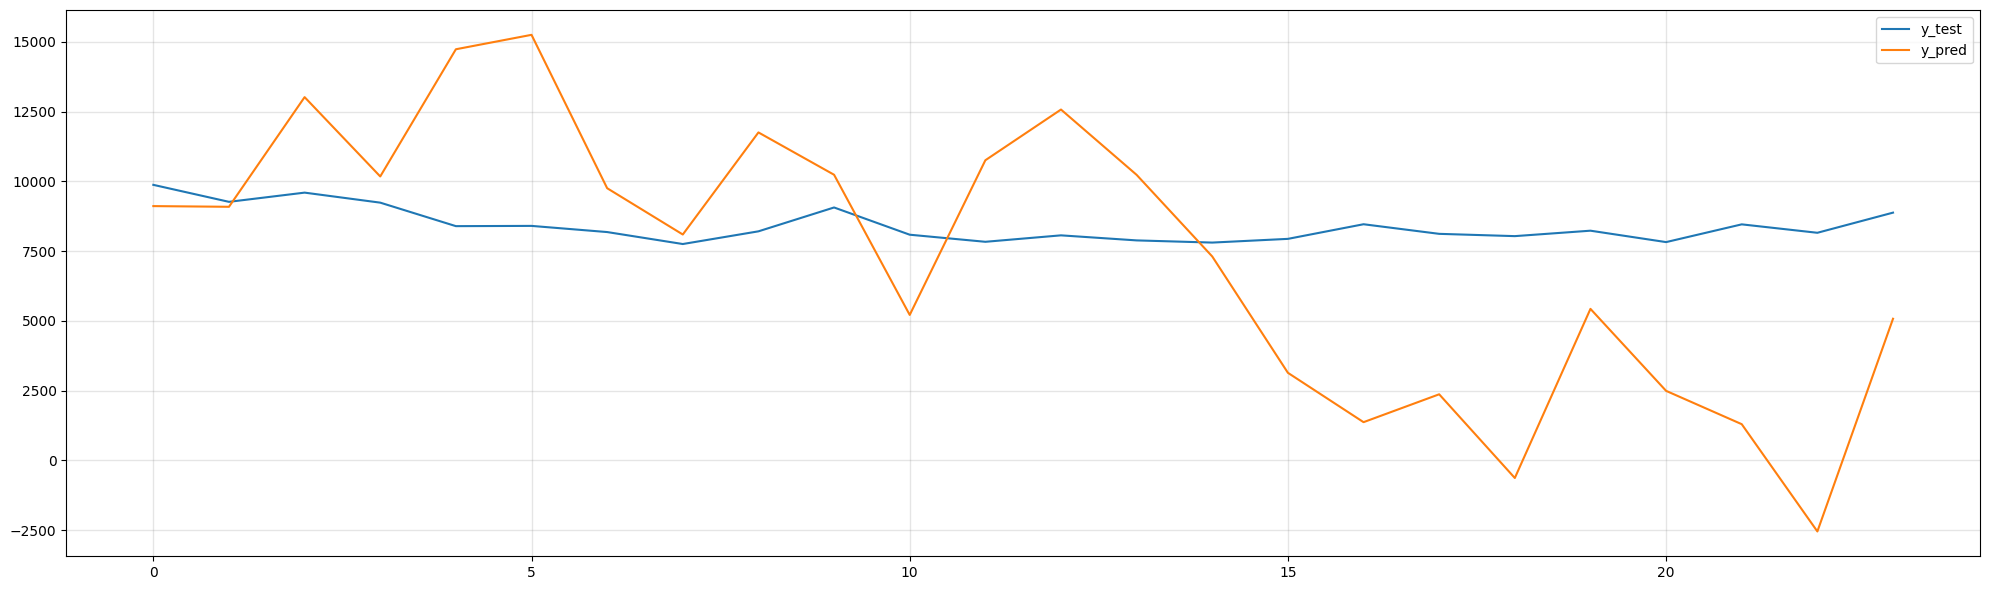

In [9]:
model = GAUNet(128, 24, random_seed=42, flip_features=False, learning_rate=0.001, level=2, device='cpu')
model.fit(x_train, y_train, eval_set=(x_test, y_test), batch_size=32,
             min_delta=0, patience=100, epochs=3000, verbose=True, lr_scheduler=None)
y_pred_inverse = scaler2.inverse_transform(model.predict(x_test))
y_test_inverse = scaler2.inverse_transform(y_test)

print(f"r2: {r2_score(y_test_inverse.T, y_pred_inverse.T)}")
print(f"mae: {mean_absolute_error(y_test_inverse, y_pred_inverse)}")
print(f"mape: {mean_absolute_percentage_error(y_test_inverse, y_pred_inverse)}")
a = plot2d(y_test_inverse, y_pred_inverse, eval_slices='[-1]', labels=['y_test', 'y_pred'], figsize=(20, 6))

# Time2VecNet

r2: 0.8372770385948494
mae: 2.786961499898275
mape: 0.02698903244076549


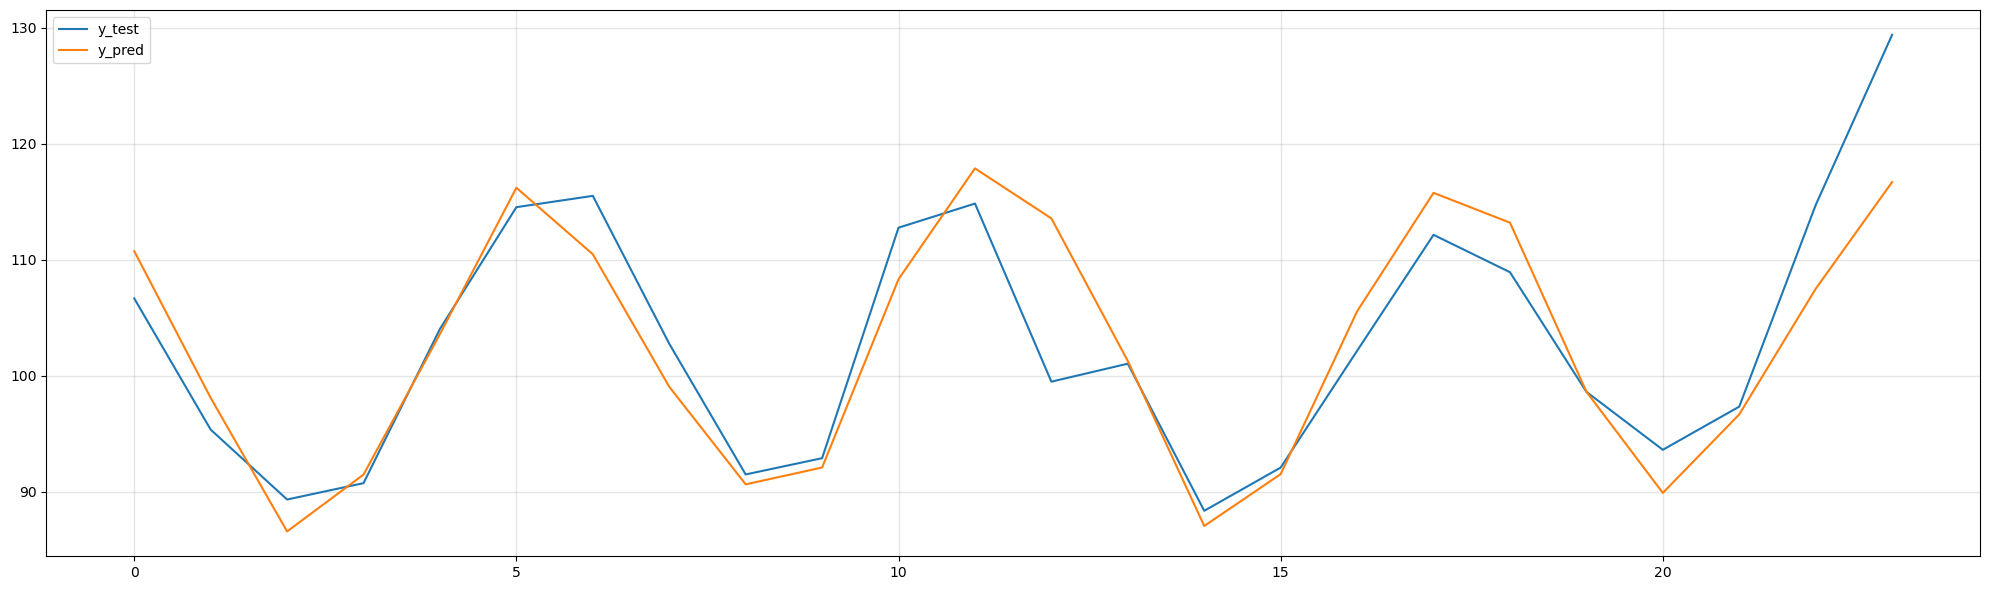

In [9]:
model = Time2VecNet(128, 24, random_seed=42, flip_features=False, learning_rate=0.001, device='cpu')
model.fit(x_train, y_train, eval_set=(x_test, y_test), batch_size=32,
             min_delta=0, patience=100, epochs=3000, verbose=False, lr_scheduler='ReduceLROnPlateau')

y_pred_inverse = model.predict(x_test)

print(f"r2: {r2_score(y_test.T, y_pred_inverse.T)}")
print(f"mae: {mean_absolute_error(y_test, y_pred_inverse)}")
print(f"mape: {mean_absolute_percentage_error(y_test, y_pred_inverse)}")
a = plot2d(y_test, y_pred_inverse, eval_slices='[-1]', labels=['y_test', 'y_pred'], figsize=(20, 6))